### A set of scripts to analyze the information loss in scarps associated with landscape evolution

### load Python packages

In [5]:
# First, import a few Python packages and landlab tools
import numpy as np
from pylab import show, figure, plot
import time
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from scipy import stats

from osgeo import gdal
import glob
from PIL import Image
import matplotlib.cbook as cbook
import scipy.optimize
from scipy.optimize import curve_fit
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
mpl.rcParams['font.size'] = 8

import warnings
warnings.filterwarnings("ignore")

### User-defined features

In [6]:
n_iter = np.array([0,2,20,200]) # number of iterations (total_time = n_iter * dt) at which to produce output, default dt=5 years

# input files and info
DEM_name = 'DEMs/RC762.asc' # set name of your DEM here 
shapefile_dir = 'Shps/RC762/' #shapefile directory
epsg_code =  32611 # Ridgecrest UTM 11N

# set output figure names
txtname = 'Figures/RC762_summary.pdf' # summary figure name 
deg_coeff_fig = 'Figures/RC762_deg_coeff_L.pdf'# degradation coefficient and length evolution figure name

### Calculate change in elevation distribution in landscape over time for the DEM

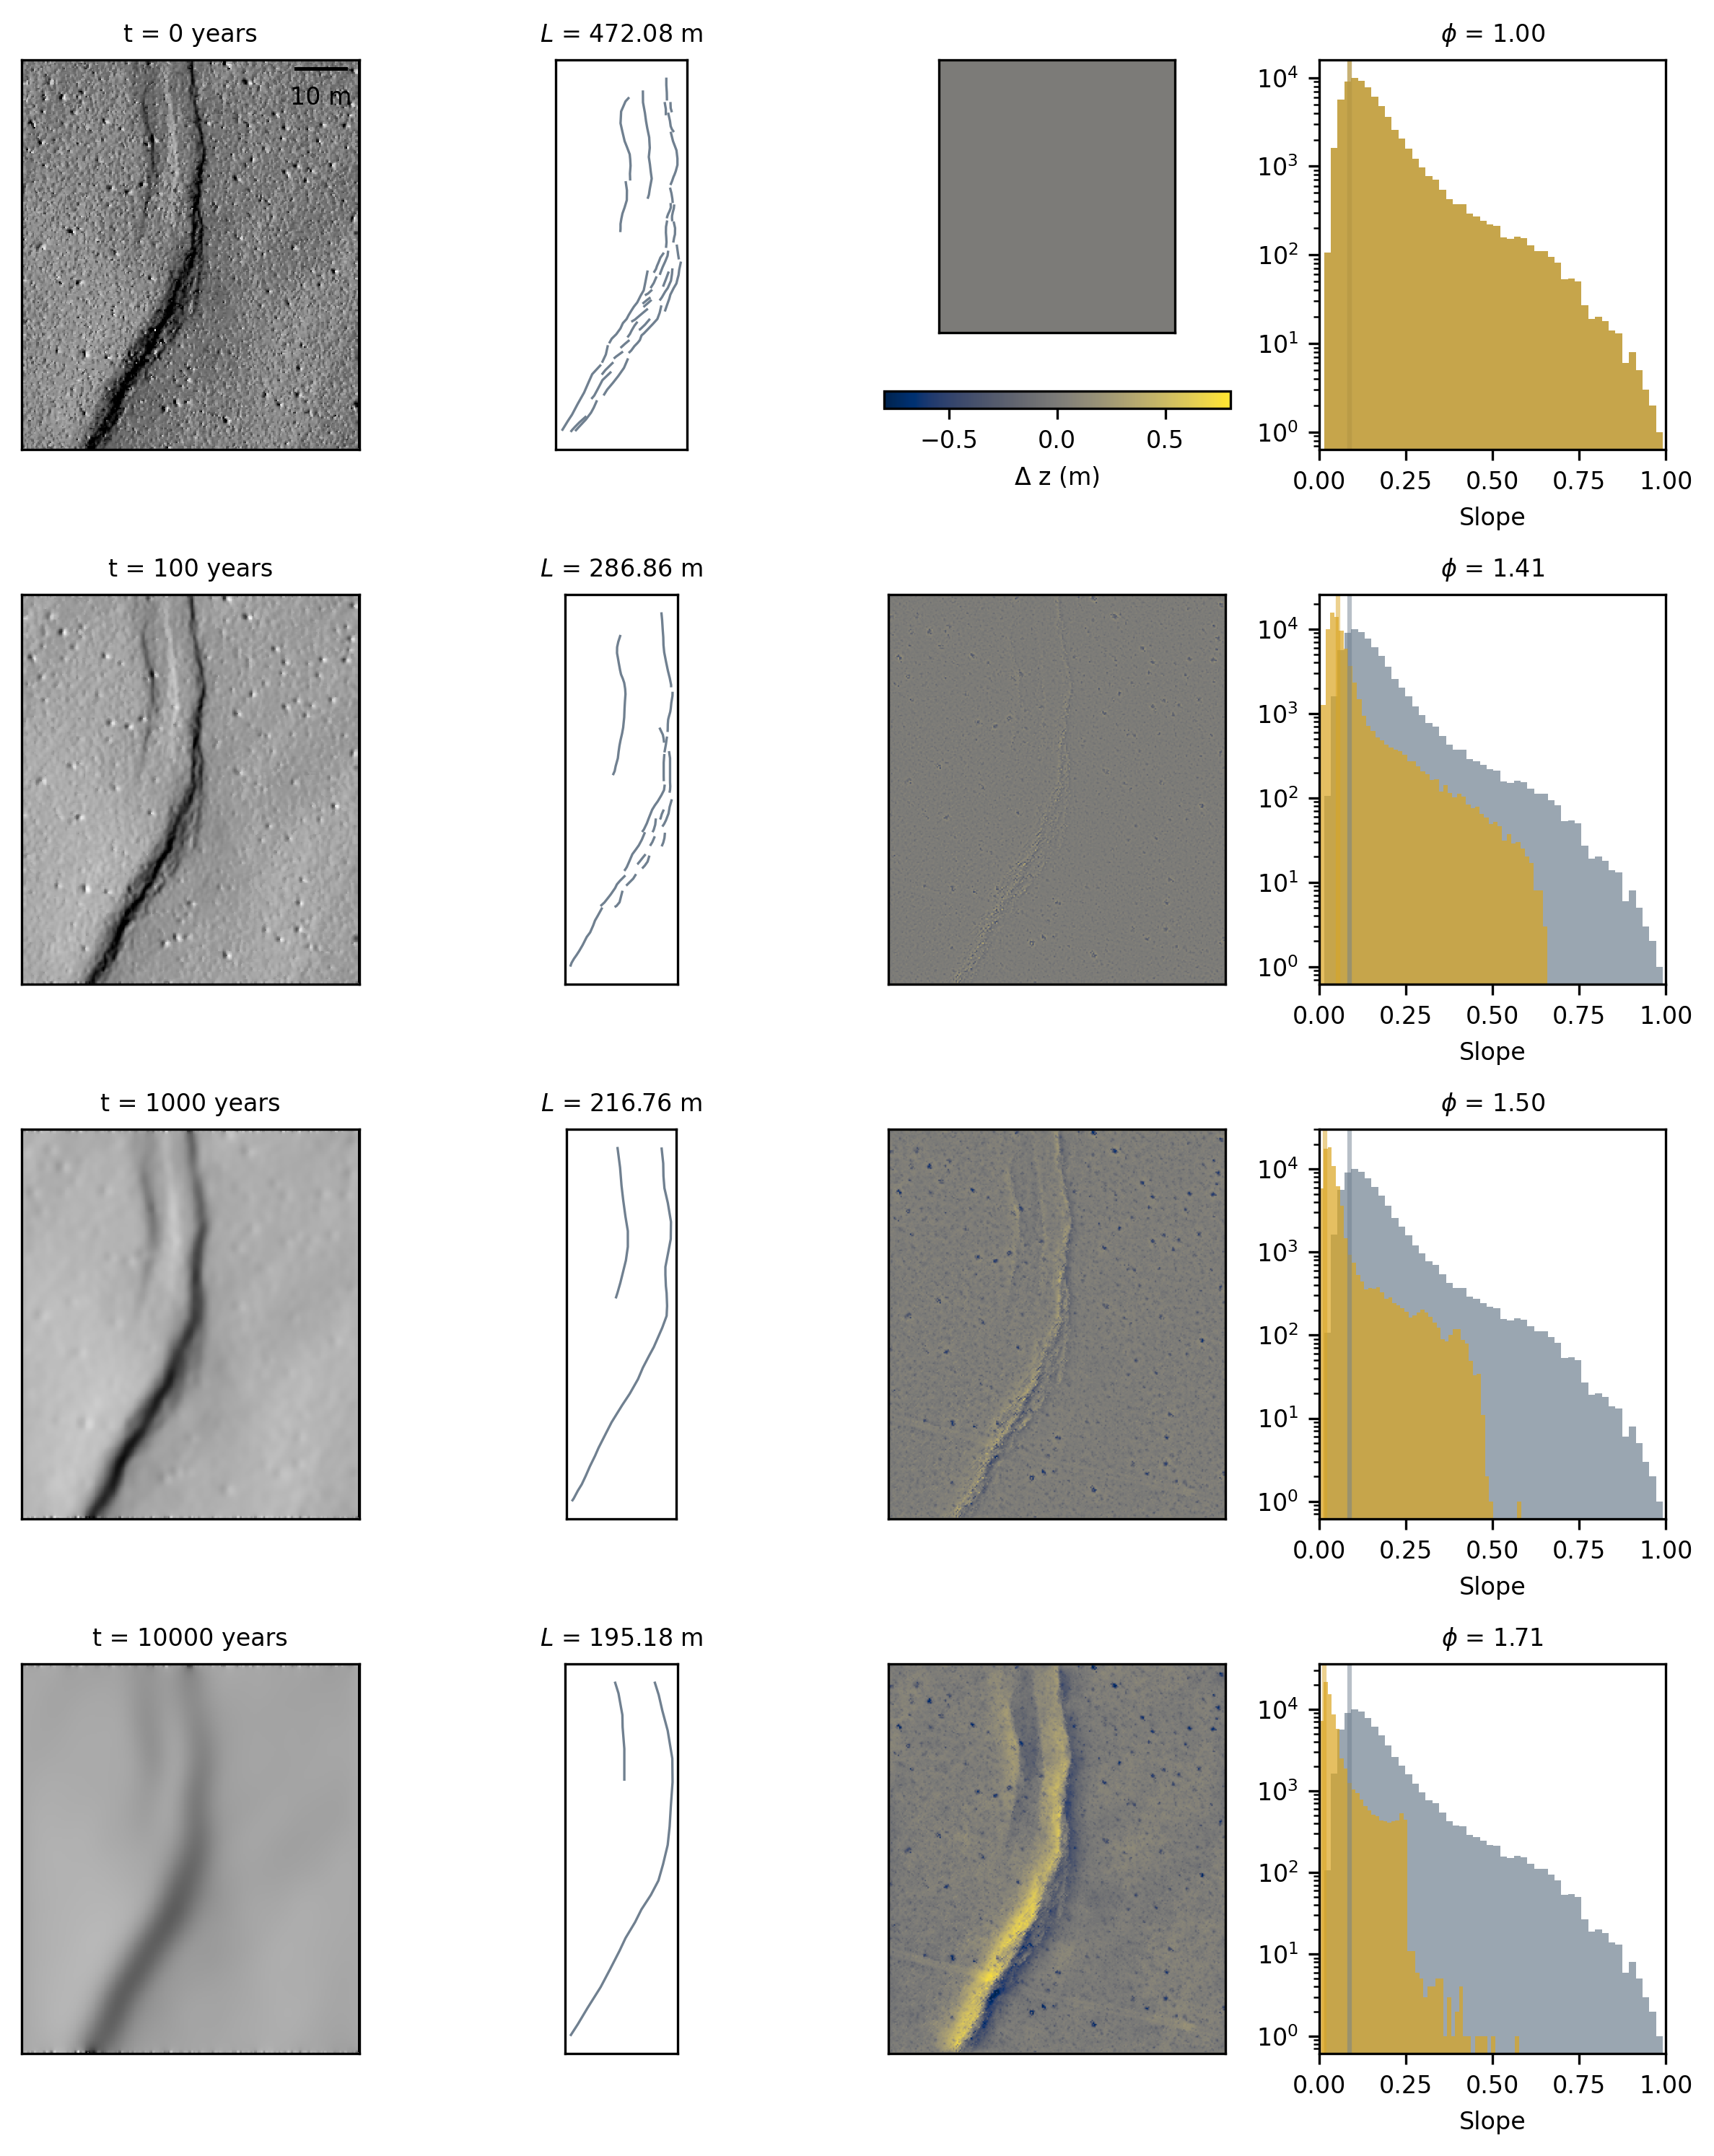

In [13]:
fig, ax = plt.subplots(
    len(n_iter),4,
    tight_layout=True,
    figsize=(8,10),
    dpi=300
)

coeff_t = []

# sort shapefiles in order for plotting later 
files = os.listdir(shapefile_dir)
shapefiles = [file for file in files if file.endswith(".shp")] # make list of shapefiles
shapefiles_sorted = sorted(shapefiles, key=lambda x: int(x.split("_")[1].split(".")[0]))
line_length = [] # for later plot

# landlab grid from DEM
mg, z = read_esri_ascii(DEM_name, name='topographic__elevation')
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
slope_t0 = mg.calc_slope_at_node(z)
slope_t0 = np.array(slope_t0)
z_t0 = z[mg.nodes]

# model set-up for 2D diffusion
D = 0.001  # m2/yr transport rate
dt = 0.2 * mg.dx * mg.dx / D # time step is 5 years 
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
qs = mg.add_zeros('sediment_flux', at='link')

# run model over time
def imshow_noticks(AX,MG):
    fig.sca(AX)
    hillshade = mg.calc_hillshade_at_node(elevs=z, alt=30., az=100.)
    imshow_grid(MG,hillshade,cmap='gray') # plot_type, 'Hillshade'
    AX.set_xticklabels([])
    AX.set_yticklabels([])
    AX.set_xticks([])
    AX.set_yticks([])
    AX.set_ylabel('')
    AX.set_xlabel('')
    colorbar = plt.gci().colorbar
    colorbar.remove()

def estimate_box_area(minx,maxx,miny,maxy):
    area = (maxx-minx)*(maxy-miny)
    return area 

plot_counter=0
for p in range(max(n_iter)+1):
    if np.any(p == n_iter):
        imshow_noticks(ax[plot_counter,0],mg) 
        slope_t = mg.calc_slope_at_node(z)
        zfin = z[mg.nodes]
        z_diff =  zfin - z_t0
        zchange = mg.node_vector_to_raster(z_diff, flip_vertically=True)
        im = ax[plot_counter,2].imshow(zchange,cmap='cividis',vmin=-0.8, vmax=0.8)
        if plot_counter == 0:
            fig.colorbar(im, ax=ax[plot_counter,2],label='$\Delta$ z (m)',orientation='horizontal')
        colorbar = plt.gci().colorbar
        ax[plot_counter,2].set_yticks([])
        ax[plot_counter,2].set_xticks([])
        slope_t = np.array(slope_t)
        slope_t0 = np.array(slope_t0)
        
        # calculate degradation coefficient
        cleaned_slope_t0 = slope_t0[~np.isnan(slope_t0)]
        cleaned_slope_t = slope_t[~np.isnan(slope_t)]
        cleaned_slope_t0 = cleaned_slope_t0[cleaned_slope_t0>0]
        cleaned_slope_t =cleaned_slope_t[cleaned_slope_t>0]
        counts_t0, bin_edges_t0 = np.histogram(cleaned_slope_t0, bins=20)
        counts_t, bin_edges_t = np.histogram(cleaned_slope_t, bins=20)
        peak_index_t0 = np.argmax(counts_t0)
        peak_index_t = np.argmax(counts_t)
        peak_t0 = 0.5 * (bin_edges_t0[peak_index_t0] + bin_edges_t0[peak_index_t0 + 1])
        peak_t = 0.5 * (bin_edges_t[peak_index_t] + bin_edges_t[peak_index_t + 1])
        ax[plot_counter,3].hist(cleaned_slope_t0, bins=50, color='slategrey', alpha=0.7, label='cleaned_slope_t0')
        ax[plot_counter,3].hist(cleaned_slope_t, bins=50, color='goldenrod', alpha=0.7, label='cleaned_slope_t')
        ax[plot_counter,3].axvline(peak_t0,color='slategrey',alpha=0.5)
        ax[plot_counter,3].axvline(peak_t,color='goldenrod',alpha=0.5)
        mode_t0 = counts_t0[peak_index_t0]
        mode_t = counts_t[peak_index_t]
        
        info_loss= mode_t/mode_t0
        coeff_t.append(info_loss)
        ax[plot_counter,3].set_title(r"$\phi$ = {:.2f}".format(info_loss),fontsize=8)
        
        ax[plot_counter,0].set_title('t = %.0f years' %(p*dt),fontsize=8)
        ax[plot_counter,3].set_xlabel('Slope',fontsize=8)
        ax[plot_counter,3].set_ylabel('')
        ax[plot_counter,3].set_yticks([])
        ax[plot_counter,3].set_yscale('log')
        #ax[plot_counter,3].set_ylim([0,6500])   
        ax[plot_counter,3].set_xlim([0,1])  
        
        shapefile_to_load = shapefile_dir + shapefiles_sorted[plot_counter]
        gdf = gpd.read_file(shapefile_to_load)
        gdf = gdf.to_crs(epsg=epsg_code)
        gdf.plot(ax=ax[plot_counter, 1],linewidth=0.8, color='slategrey')
        ax[plot_counter,1].set_ylabel('')
        ax[plot_counter,1].set_yticks([])
        ax[plot_counter,1].set_xlabel('')
        ax[plot_counter,1].set_xticks([])     
        ax[plot_counter,1].set_aspect('equal')   
        gdf['length'] = gdf.geometry.length
        total_length = gdf.geometry.length.sum()
        # area = estimate_box_area()
        ax[plot_counter,1].set_title(r"$L$ = {:.2f} m".format(total_length),fontsize=8)
        line_length.append(total_length)
        plot_counter += 1
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt  

scalebar = ScaleBar(
    0.5,
    units="m",
    dimension="si-length",
    label=None,
    length_fraction=None,
    height_fraction=None,
    width_fraction=None,
    location=None,
    pad=None,
    border_pad=None,
    sep=None,
    frameon=None,
    color=None,
    box_color=None,
    box_alpha=0,
    scale_loc=None,
    label_loc=None,
    font_properties=None,
    label_formatter=None,
    scale_formatter=None,
    fixed_value=None,
    fixed_units=None,
    animated=False,
    rotation=None,
)
ax[0,0].add_artist(scalebar)
plt.subplots_adjust(left=0.05, right=1, bottom=0.05, top=0.95, wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig(txtname)


### Plot degradation coefficient and line length change over time

We define the degradation coefficient $\phi$ as:

\begin{equation}

\phi = \frac{{mod(slope_{t0})}}{{mod(slope_{t})}}

\end{equation}


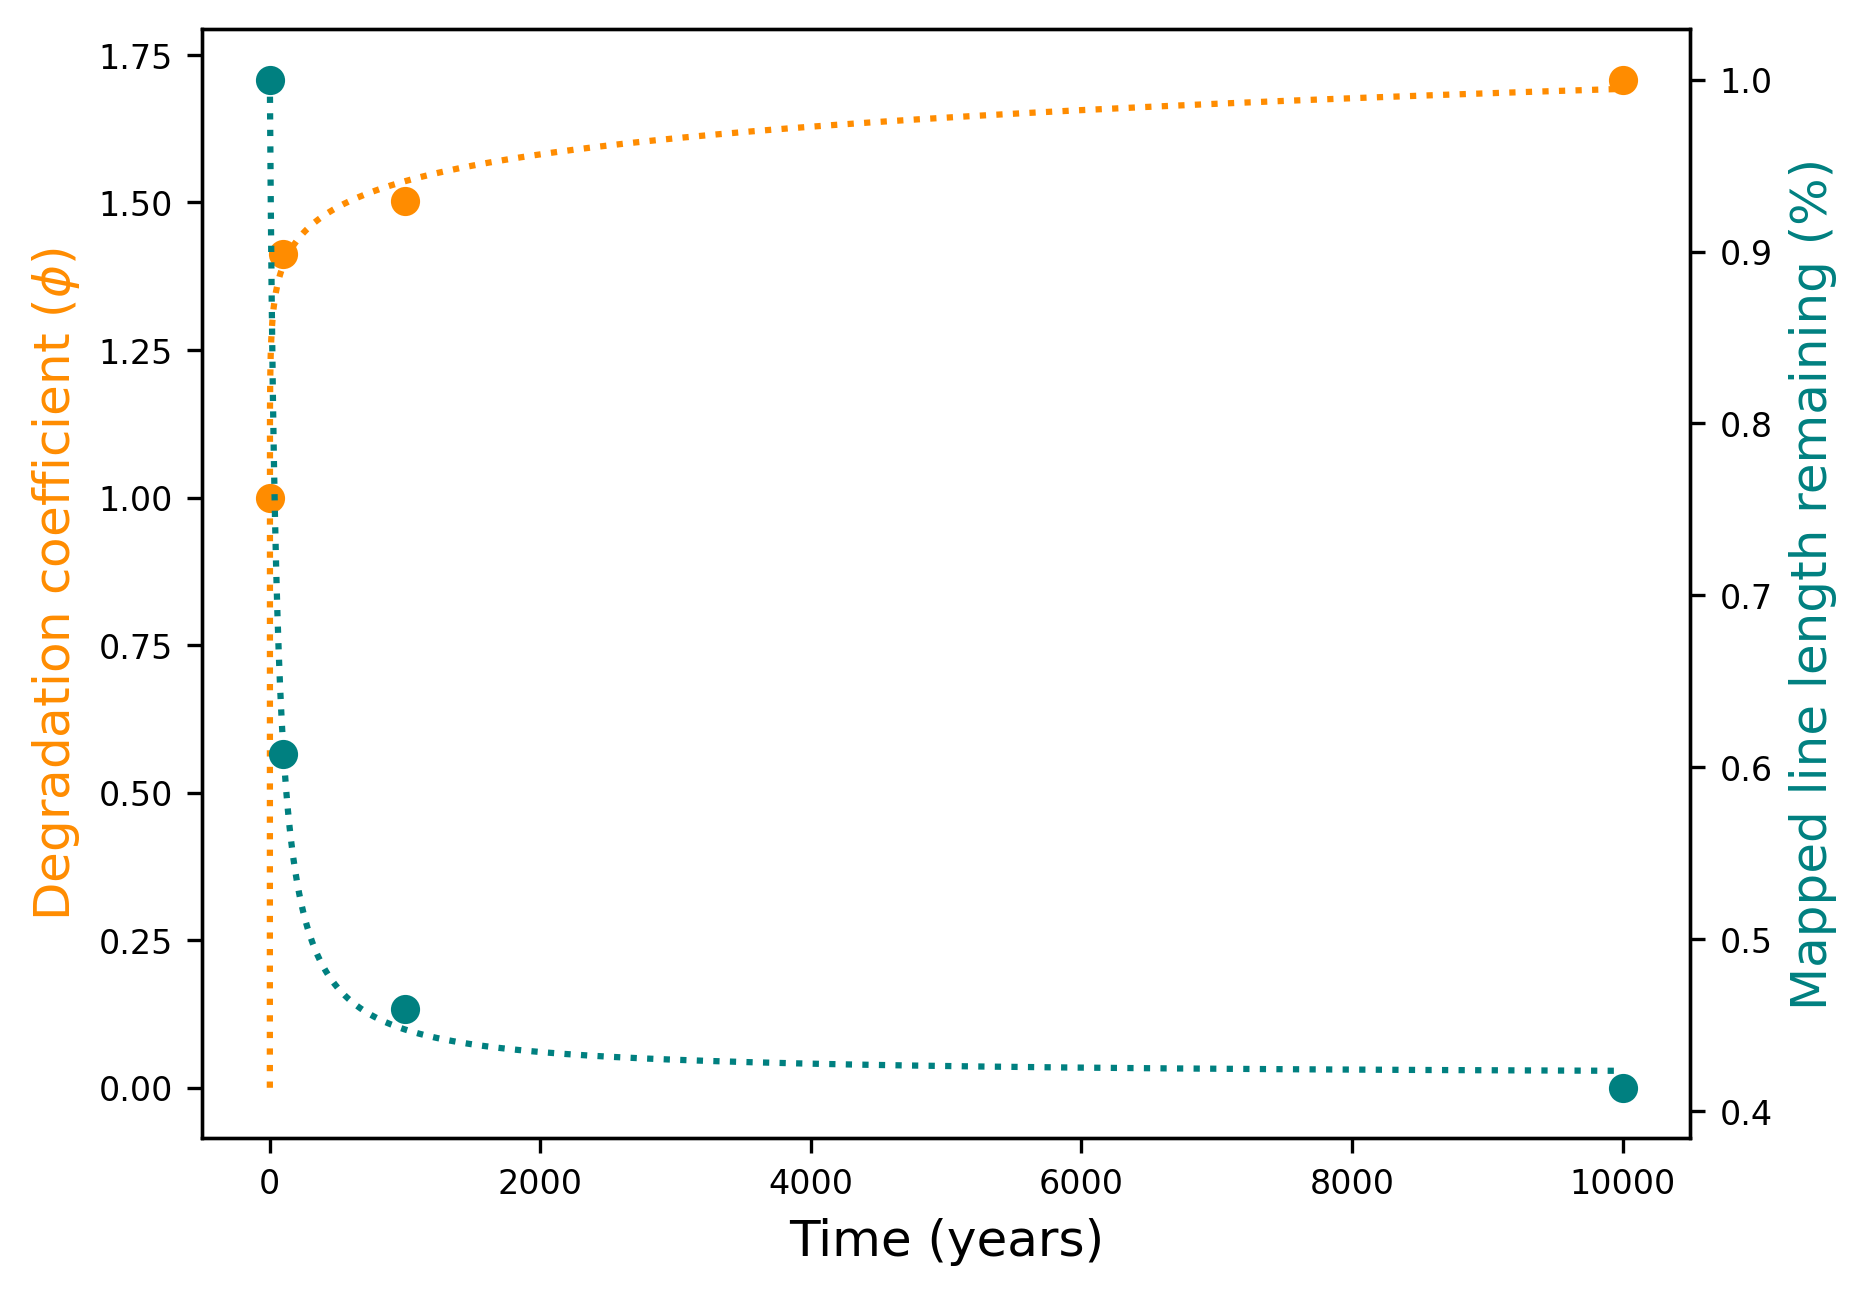

In [18]:
fig, ax1 = plt.subplots(dpi=300)

# landlab grid from DEM
mg, z = read_esri_ascii(DEM_name, name='topographic__elevation')
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
slope_t0 = mg.calc_slope_at_node(z)
slope_t0 = np.array(slope_t0)
z_t0 = z[mg.nodes]

# model set-up for 2D diffusion
D = 0.001  # m2/yr transport rate
dt = 0.2 * mg.dx * mg.dx / D # time step is 5 years 
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
qs = mg.add_zeros('sediment_flux', at='link')


ax2 = ax1.twinx()
plot_counter = 0
for p in range(max(n_iter)+1):
    if np.any(p == n_iter):
        ax1.scatter(p*dt,coeff_t[plot_counter],color='darkorange')
        ax2.scatter(p*dt,line_length[plot_counter]/line_length[0],color='teal')
        plot_counter += 1
        
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt  


def func_deg_coeff(x,a,c):
    return x**a * c

def func_line_length(x,a,b,c):
    return b - (c * x) / (x + a)

time = np.zeros(4)
for n in range(len(n_iter)):
    time[n] = n_iter[n]*dt 

popt_deg, pcov_deg = curve_fit(func_deg_coeff, time, coeff_t)
popt_line, pcov_line= curve_fit(func_line_length, time, line_length/line_length[0])

x = np.linspace(min(time),max(time),10000)


ax1.plot(x,func_deg_coeff(x, *popt_deg),color='darkorange',linestyle=':')
ax2.plot(x,func_line_length(x, *popt_line),color='teal',linestyle=':')
ax1.set_ylabel('Degradation coefficient ($\phi$)',c='darkorange',fontsize=12)
ax1.set_xlabel('Time (years)',fontsize=12)
ax2.set_ylabel('Mapped line length remaining (%)',c='teal',fontsize=12)

plt.savefig(deg_coeff_fig)
plt.show()